In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/china-cancer-patient-records/china_cancer_patients_synthetic.csv


In [20]:
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 69.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 39.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
  

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from datetime import datetime
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

## 1. Data Loading and Exploration

In [8]:
# Load data, view basic info, view top 5 entries and null values
df = pd.read_csv('/kaggle/input/china-cancer-patient-records/china_cancer_patients_synthetic.csv')

print("\nDataset info:")
print(df.info())
print("\nFirst 5 Entries:")
print(df.head())
print("nNull Values:")
print(df.isnull().sum())
print("\nBasic Statistics:")
print(df.describe(include='all'))


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PatientID             10000 non-null  object 
 1   Gender                10000 non-null  object 
 2   Age                   10000 non-null  int64  
 3   Province              10000 non-null  object 
 4   Ethnicity             10000 non-null  object 
 5   TumorType             10000 non-null  object 
 6   CancerStage           10000 non-null  object 
 7   DiagnosisDate         10000 non-null  object 
 8   TumorSize             10000 non-null  float64
 9   Metastasis            10000 non-null  object 
 10  TreatmentType         10000 non-null  object 
 11  SurgeryDate           4327 non-null   object 
 12  ChemotherapySessions  10000 non-null  int64  
 13  RadiationSessions     10000 non-null  int64  
 14  SurvivalStatus        10000 non-null  object 
 15  Follo

In [9]:
# Check unique values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nUnique Values in Categorical Columns:")
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")


Unique Values in Categorical Columns:
PatientID: 10000 unique values
Gender: 3 unique values
Province: 13 unique values
Ethnicity: 6 unique values
TumorType: 6 unique values
CancerStage: 4 unique values
DiagnosisDate: 4383 unique values
Metastasis: 2 unique values
TreatmentType: 5 unique values
SurgeryDate: 2915 unique values
SurvivalStatus: 2 unique values
SmokingStatus: 3 unique values
AlcoholUse: 2 unique values
GeneticMutation: 3 unique values
Comorbidities: 9 unique values


**Key Observations:**

- Class imbalance in SurvivalStatus (78% Alive) may require techniques like SMOTE or class weights during modeling.
- High missingness in GeneticMutation and AlcoholUse suggests these features may need special handling or exclusion.
- Date features (DiagnosisDate, SurgeryDate) offer opportunities for feature engineering (e.g., time intervals).
- Skewed numerical features (ChemotherapySessions, RadiationSessions) may benefit from log-transformation or binning.
- Dominant categories (e.g., Han ethnicity, Guangdong province) may reduce the predictive power of these features.

## 2. Exploratory Data Analysis

In [10]:
# Set visualization style
plt.style.use('seaborn')
sns.set_palette('viridis')

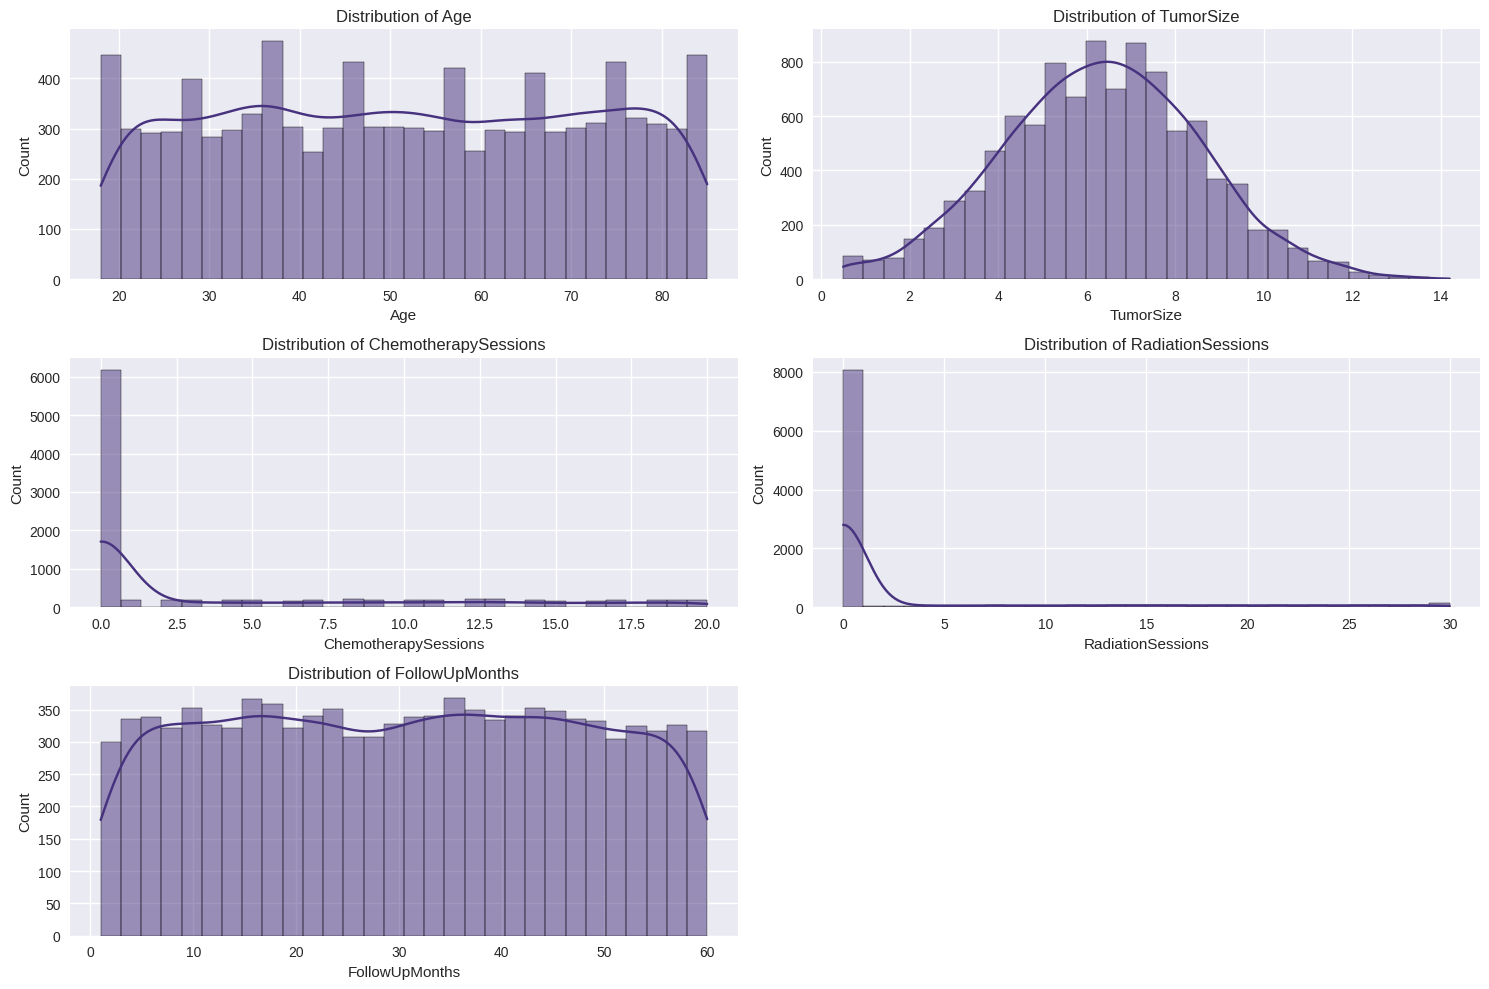

In [11]:
# Numerical features distribution
numerical_cols = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

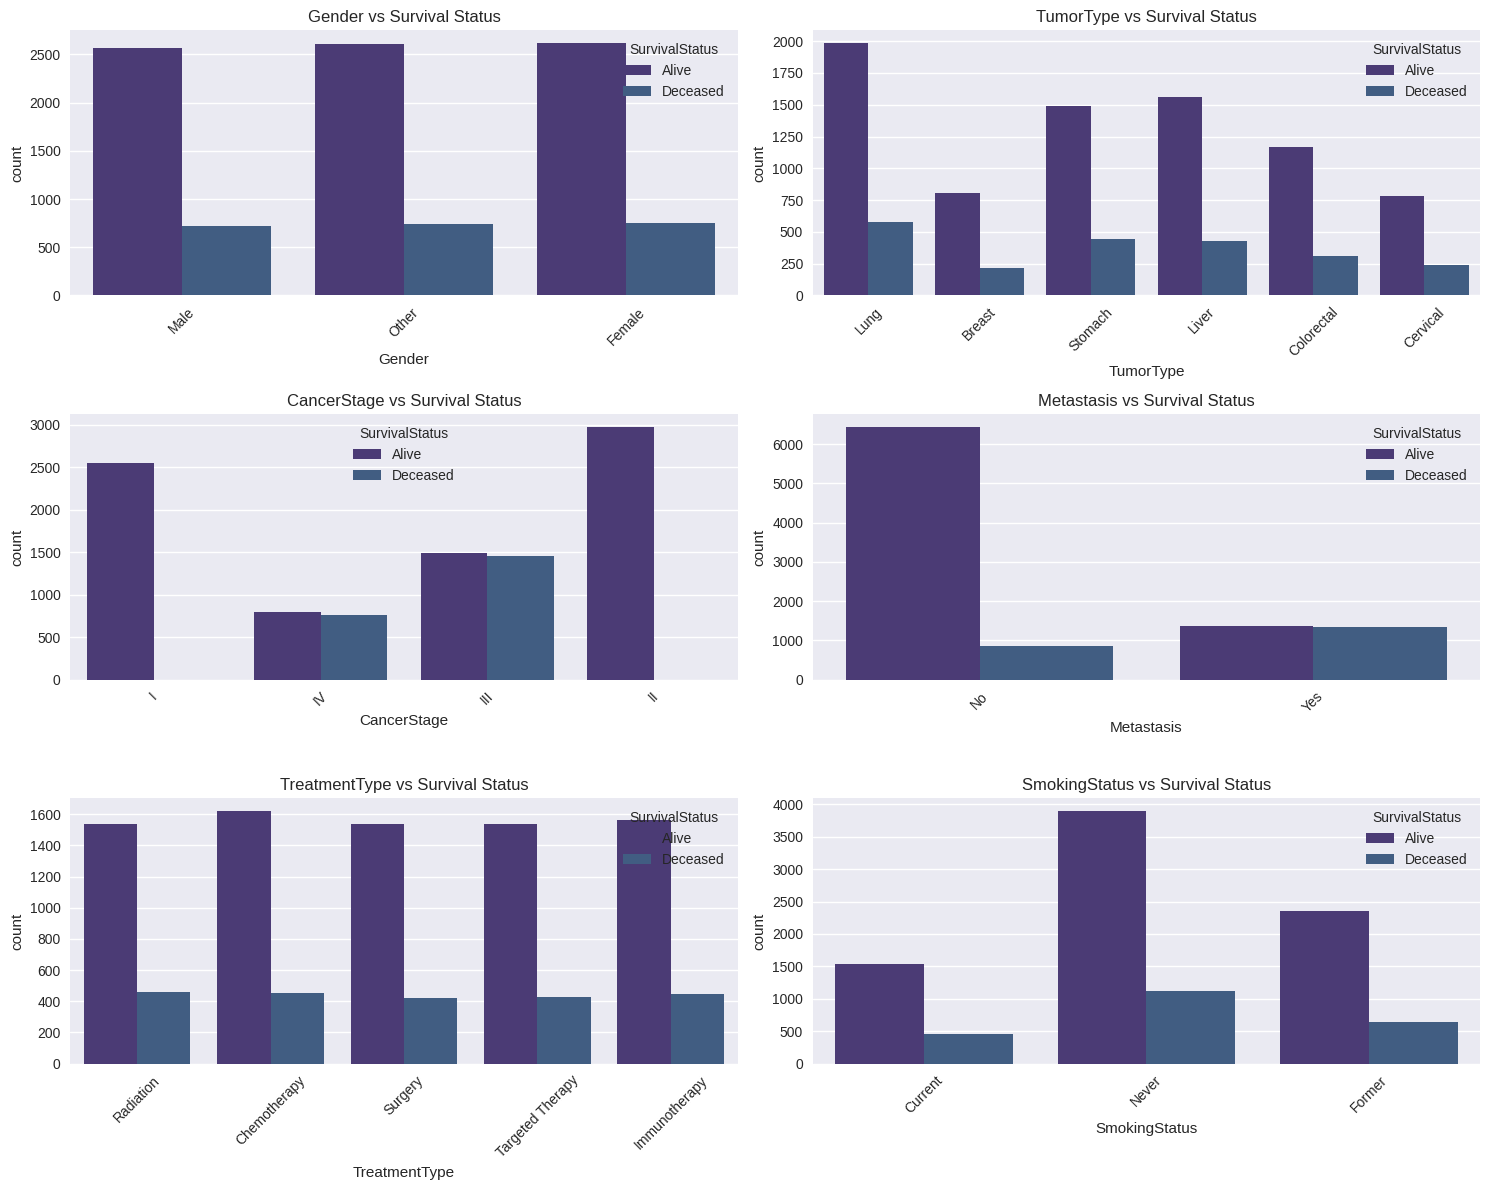

In [12]:
# Categorical features count plots
key_categorical_cols = ['Gender', 'TumorType', 'CancerStage', 'Metastasis', 'TreatmentType', 'SmokingStatus']
plt.figure(figsize=(15, 12))
for i, col in enumerate(key_categorical_cols, 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=df, x=col, hue='SurvivalStatus')
    plt.title(f'{col} vs Survival Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

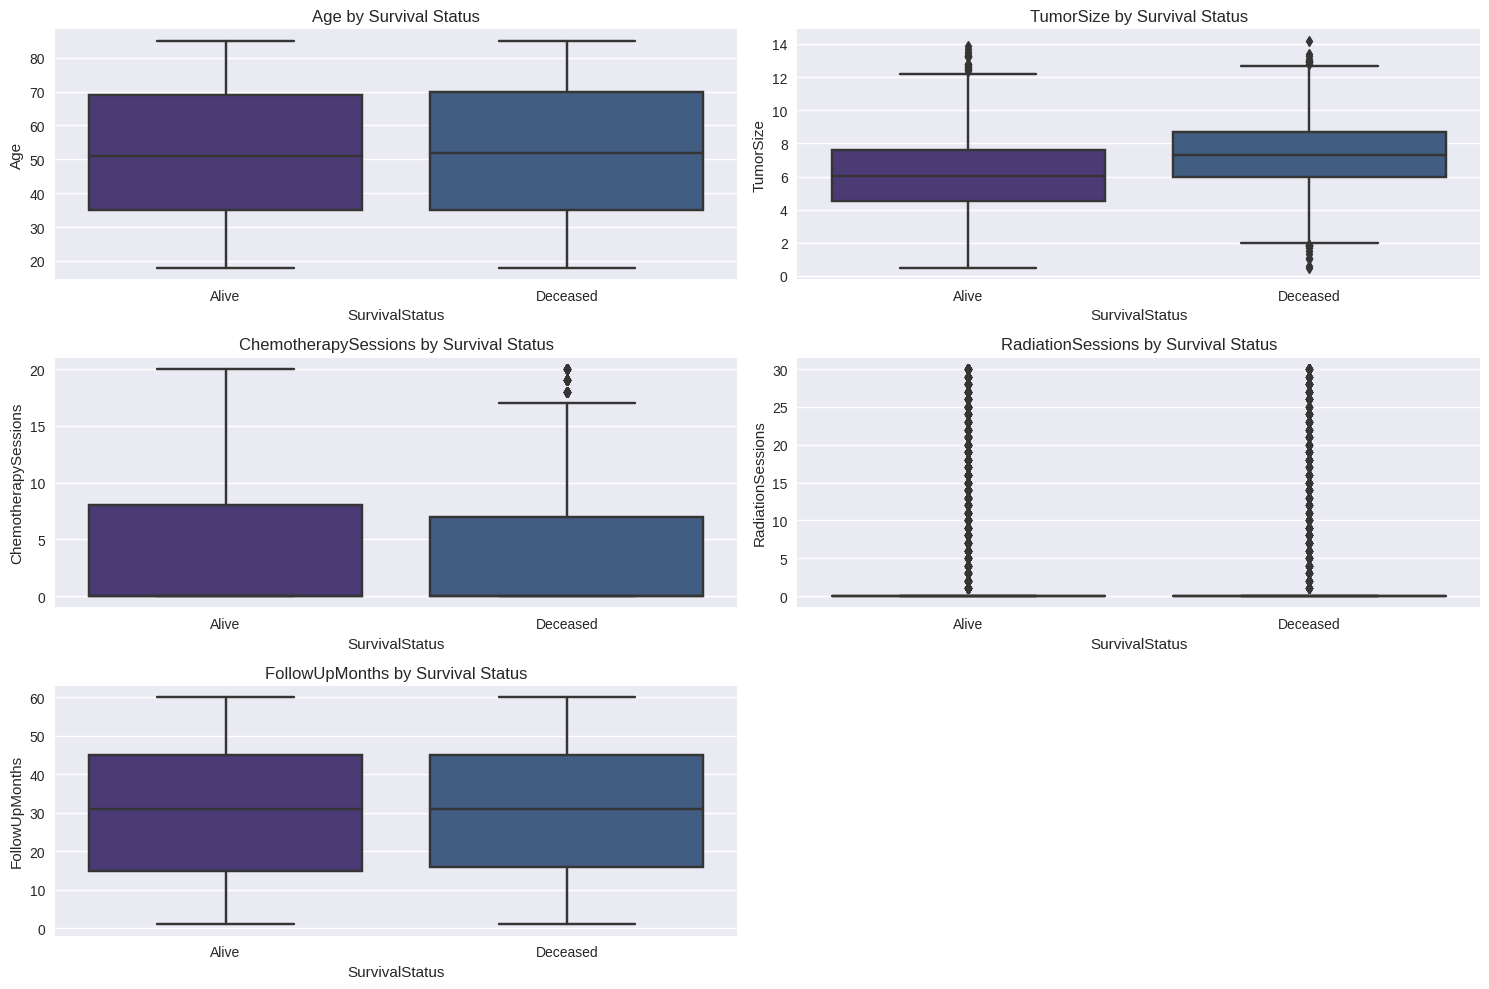

In [13]:
# Box plots for numerical features vs SurvivalStatus
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(data=df, x='SurvivalStatus', y=col)
    plt.title(f'{col} by Survival Status')
plt.tight_layout()
plt.show()

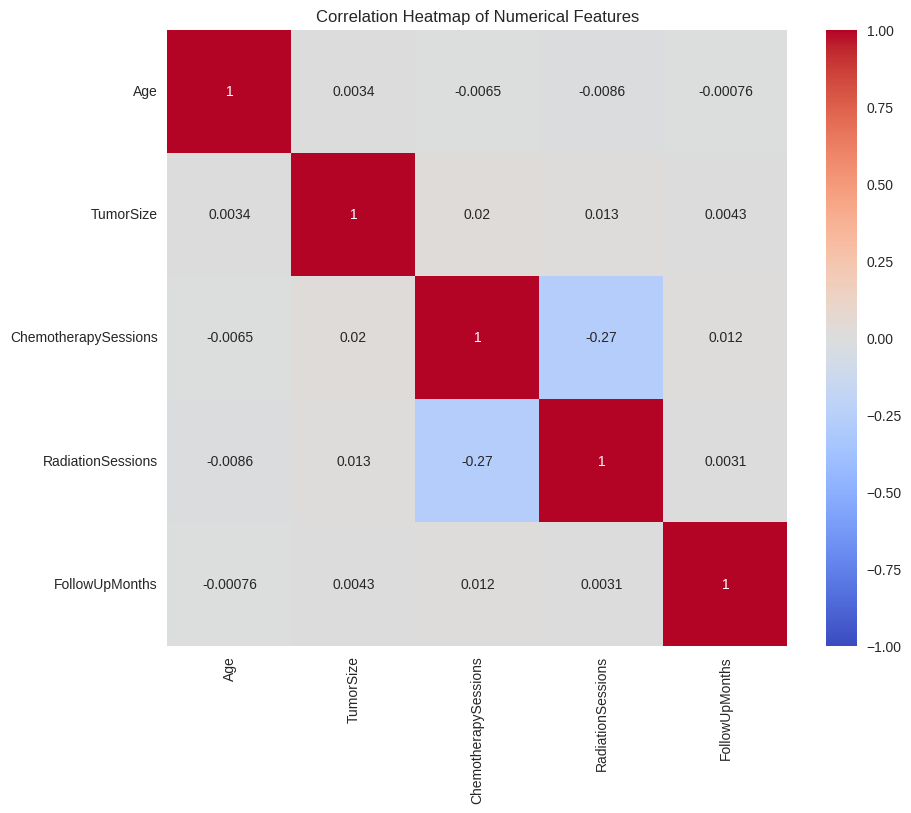

In [14]:
# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

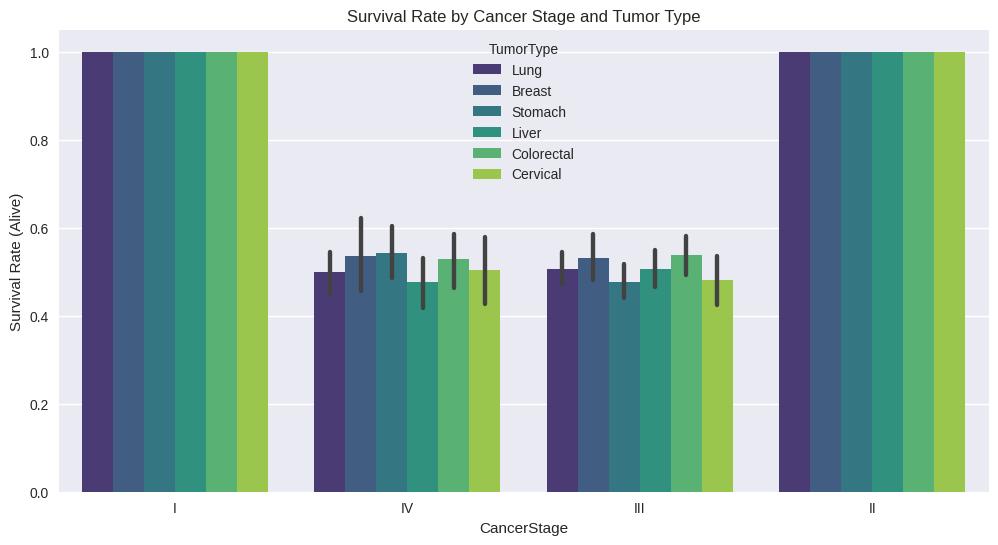

In [15]:
# Survival rate by CancerStage and TumorType
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='CancerStage', y=df['SurvivalStatus'].map({'Alive': 1, 'Deceased': 0}), hue='TumorType')
plt.title('Survival Rate by Cancer Stage and Tumor Type')
plt.ylabel('Survival Rate (Alive)')
plt.show()

In [16]:
# Print survival rate statistics
print("\nSurvival Rate by Cancer Stage:")
print(df.groupby('CancerStage')['SurvivalStatus'].value_counts(normalize=True).unstack())
print("\nSurvival Rate by Tumor Type:")
print(df.groupby('TumorType')['SurvivalStatus'].value_counts(normalize=True).unstack())


Survival Rate by Cancer Stage:
SurvivalStatus     Alive  Deceased
CancerStage                       
I               1.000000       NaN
II              1.000000       NaN
III             0.505453  0.494547
IV              0.511269  0.488731

Survival Rate by Tumor Type:
SurvivalStatus     Alive  Deceased
TumorType                         
Breast          0.789577  0.210423
Cervical        0.767123  0.232877
Colorectal      0.788761  0.211239
Liver           0.785930  0.214070
Lung            0.775478  0.224522
Stomach         0.769788  0.230212


#### **Analysis of Results**

**1. Distribution of Numerical Features**

- **Age:**
    - Distribution roughly uniform across 20–80 years, with peaks around 30, 50, and 70 years.
    - Suggests a broad age range, which may influence survival outcomes (e.g., older patients might have worse prognosis).
- **TumorSize:**
    - Right-skewed, peaking around 6–8 cm, with a range of 0.5–14.2 cm.
    - Skewness suggests potential for log-transformation to normalize the distribution for modeling.
- **ChemotherapySessions:**
    - Highly right-skewed, with a large peak at 0 sessions (around 5,000 patients) and a long tail up to 20 sessions.
    - Most patients received no chemotherapy, which aligns with TreatmentType distributions. Binning or log-transformation may help.
- **RadiationSessions:**
    - Similarly right-skewed, with a peak at 0 sessions (around 6,000 patients) and a tail up to 30 sessions.
    - Indicates radiation is less common, and similar preprocessing (binning/log-transform) may be needed.
- **FollowUpMonths:**
    - Bimodal distribution with peaks around 10–20 and 40–50 months, ranging from 1 to 60 months.
    - Suggests variability in follow-up duration, which could be related to survival status (e.g., deceased patients may have shorter follow-ups).
      
**2. Categorical Features vs Survival Status**

- **Gender vs Survival Status:**
    - Females have the highest count of both Alive (around 2,500) and Deceased (around 800), followed by Males and Other.
    - Survival proportions seem similar across genders, suggests gender may not be a strong predictor.
- **TumorType vs Survival Status:**
    - Lung cancer has the highest count (around 2,000 Alive, 500 Deceased), followed by Breast and Stomach.
    - Survival rates relatively consistent across tumor types (around 77–79% Alive), indicates tumor type may have moderate predictive power.
- **CancerStage vs Survival Status:**
    - Stages I and II have 100% survival, while Stages III and IV have around 50% survival.
    - Highlights CancerStage as a critical predictor of survival.
- **Metastasis vs Survival Status:**
    - Patients with no metastasis (around 5,500 Alive, 1,500 Deceased) have a higher survival rate than those with metastasis (around 2,000 Alive, 1,000 Deceased).
    - Metastasis appears to be a strong predictor of worse survival outcomes.
- **TreatmentType vs Survival Status:**
    - Chemotherapy and Surgery are the most common treatments, each with around 1,500 Alive and 500 Deceased.
    - Survival rates seem similar across treatment types, suggesting treatment type may not strongly differentiate survival status.
- **SmokingStatus vs Survival Status:**
    - Never smokers have the highest count (around 3,500 Alive, 1,000 Deceased), followed by Current and Former.
    - Survival proportions are similar across smoking statuses, suggesting limited predictive power.
  
**3. Numerical Features by Survival Status (Box Plots):**

- **Age by Survival Status:**
    - Median age for Alive and Deceased is similar (around 50), with a slightly wider interquartile range (IQR) for Deceased.
    - No significant difference, suggesting age may not be a strong predictor.
- **TumorSize by Survival Status:**
    - Median tumor size is slightly higher for Deceased (around 6.5 cm) than Alive (around 6 cm), with more outliers for Deceased.
    - May mean larger tumors may be associated with worse outcomes, but the difference is small.
- **ChemotherapySessions by Survival Status:**
    - Median is 0 for both groups, but Deceased patients have a slightly higher IQR and more outliers (up to 20 sessions).
    - Indicates chemotherapy may be more common among deceased patients, possibly due to advanced disease.
- **RadiationSessions by Survival Status:**
    - Median is 0 for both, but Deceased patients have more outliers (up to 30 sessions).
    - Similar to chemotherapy, radiation may be associated with more severe cases.
- **FollowUpMonths by Survival Status:**
    - Median follow-up for Alive is slightly higher (around 35 months) than Deceased (around 30 months).
    - Suggests deceased patients may have shorter follow-up periods, possibly due to earlier mortality.

**4. Correlation Heatmap of Numerical Features:**

- **Key Correlations:**
    - ChemotherapySessions and RadiationSessions have a negative correlation (-0.27), indicating patients typically receive one or the other, not both.
    - Other correlations are very weak (close to 0), suggesting numerical features are mostly independent.
- **Implication:**
    - Low correlations mean multicollinearity is not a concern for modeling, but the lack of strong relationships with FollowUpMonths suggests limited direct linear relationships with survival duration.
 
**5. Survival Rate by Cancer Stage and Tumor Type:**
- CancerStage is a dominant predictor, with early stages (I, II) having perfect survival and advanced stages (III, IV) showing a balanced outcome.
- Tumor types have similar survival rates (77–79%), suggesting tumor type may not add much additional predictive power beyond stage.

**6. Key Takeaways for Preprocessing and Modeling**

- 78% Alive vs. 22% Deceased requires techniques like SMOTE or class weights to ensure the model doesn’t over-predict the majority class.
- CancerStage and Metastasis are likely strong predictors based on survival rate differences.
- Features with missing values like GeneticMutation (72% missing) and AlcoholUse (59% missing) need careful handling—possibly imputation or exclusion.
- Date features (DiagnosisDate, SurgeryDate) can be used to compute time intervals (e.g., time since diagnosis).
- Skewed numerical features (ChemotherapySessions, RadiationSessions) may benefit from log-transformation or binning.
- Features with limited variability (e.g., Ethnicity with 91% Han, Gender, SmokingStatus) may have low predictive power and could be dropped if they don’t improve model performance.
- Numerical features like Age and TumorSize will be scaled for models sensitive to feature magnitudes like logistic regression.

## 3. Preprocessing and Feature Engineering

In [23]:
# Create a copy of the original dataframe
df_processed = df.copy()

In [24]:
# Drop PatientID as it's a unique identifier with no predictive value
df_processed = df_processed.drop('PatientID', axis=1)

In [25]:
# Handle missing values

# SurgeryDate: Create a binary indicator for surgery and impute missing dates
df_processed['HadSurgery'] = df_processed['SurgeryDate'].notnull().astype(int)
df_processed = df_processed.drop('SurgeryDate', axis=1)

# AlcoholUse: Impute with 'Unknown' since missingness is high (59%)
df_processed['AlcoholUse'] = df_processed['AlcoholUse'].fillna('Unknown')

# GeneticMutation: Impute with 'None' due to high missingness (72%)
df_processed['GeneticMutation'] = df_processed['GeneticMutation'].fillna('None')

# Comorbidities: Impute with 'None' for missing values
df_processed['Comorbidities'] = df_processed['Comorbidities'].fillna('None')

In [26]:
# Feature Engineering: Calculate time since diagnosis
df_processed['DiagnosisDate'] = pd.to_datetime(df_processed['DiagnosisDate'])
current_date = pd.to_datetime('2025-05-17')  # Current date
df_processed['MonthsSinceDiagnosis'] = (current_date - df_processed['DiagnosisDate']).dt.days / 30.42  # Approximate months
df_processed = df_processed.drop('DiagnosisDate', axis=1)

In [27]:
# Encode categorical variables
categorical_cols = df_processed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'SurvivalStatus':  # Target variable will be encoded separately
        if df_processed[col].nunique() > 5:  # Use label encoding for high-cardinality features
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
        else:  # Use one-hot encoding for low-cardinality features
            df_processed = pd.get_dummies(df_processed, columns=[col], drop_first=True)

# Encode target variable
df_processed['SurvivalStatus'] = df_processed['SurvivalStatus'].map({'Alive': 1, 'Deceased': 0})

In [28]:
# Scale numerical features
numerical_cols = ['Age', 'TumorSize', 'ChemotherapySessions', 'RadiationSessions', 'FollowUpMonths', 'MonthsSinceDiagnosis']
scaler = StandardScaler()
df_processed[numerical_cols] = scaler.fit_transform(df_processed[numerical_cols])

In [29]:
# Create a copy for hyperparameter tuning
df_tuning = df_processed.copy()

In [30]:
# Address class imbalance using SMOTE
X = df_processed.drop('SurvivalStatus', axis=1)
y = df_processed['SurvivalStatus']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c3388431a80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

In [31]:
# Combine resampled data back into a dataframe
df_processed = pd.DataFrame(X_resampled, columns=X.columns)
df_processed['SurvivalStatus'] = y_resampled

## 4. Model Development

In [34]:
# Define features and target
X = df_processed.drop('SurvivalStatus', axis=1)
y = df_processed['SurvivalStatus']

In [35]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

In [37]:
# Evaluate each model using cross-validation
results = {}
for name, model in models.items():
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    results[name] = {
        'CV Mean F1': cv_scores.mean(),
        'CV Std F1': cv_scores.std()
    }
    # Fit model on training data
    model.fit(X_train, y_train)
    # Predict on test set
    y_pred = model.predict(X_test)
    # Calculate metrics
    results[name].update({
        'Test Accuracy': accuracy_score(y_test, y_pred),
        'Test Precision': precision_score(y_test, y_pred),
        'Test Recall': recall_score(y_test, y_pred),
        'Test F1': f1_score(y_test, y_pred)
    })

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4987, number of negative: 4984
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1601
[LightGBM] [Info] Number of data points in the train set: 9971, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500150 -> initscore=0.000602
[LightGBM] [Info] Start training from score 0.000602
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4986, number of negative: 4985
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise

In [38]:
# Print results
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Logistic Regression:
CV Mean F1: 0.8418
CV Std F1: 0.0061
Test Accuracy: 0.8453
Test Precision: 0.9069
Test Recall: 0.7694
Test F1: 0.8325

Random Forest:
CV Mean F1: 0.8539
CV Std F1: 0.0055
Test Accuracy: 0.8723
Test Precision: 0.9524
Test Recall: 0.7836
Test F1: 0.8598

XGBoost:
CV Mean F1: 0.8626
CV Std F1: 0.0051
Test Accuracy: 0.8553
Test Precision: 0.8819
Test Recall: 0.8202
Test F1: 0.8499

LightGBM:
CV Mean F1: 0.8590
CV Std F1: 0.0105
Test Accuracy: 0.8610
Test Precision: 0.9072
Test Recall: 0.8041
Test F1: 0.8526


In [39]:
# Store the best model (based on test F1 score)
best_model_name = max(results, key=lambda x: results[x]['Test F1'])
best_model = models[best_model_name]
print(f"\nBest model: {best_model_name}")


Best model: Random Forest


**Observations:**

- All models perform well (Test F1 > 0.83), likely due to the balanced dataset after SMOTE and effective preprocessing.
- Tree-based models (Random Forest, XGBoost, LightGBM) outperform Logistic Regression, a sign that non-linear relationships and interactions between features (e.g., CancerStage, Metastasis) are important.
- Recall is consistently lower than precision across all models, suggesting the models are more conservative in predicting Alive, possibly due to feature distributions or class boundary complexity.
- Random Forest is the best model with a Test F1 of 0.8598.
- Its high precision is particularly valuable in a medical context, where false positives (predicting Alive when the patient is Deceased) could lead to inappropriate treatment decisions.
- The moderate recall suggests there’s room for improvement in identifying all Alive cases, which we’ll address through hyperparameter tuning.

## 5. Recommendations for Medical Stakeholders

1. Prioritize Early Cancer Detection and Staging:
    - **Insight:** The EDA showed 100% survival for patients in Cancer Stages I and II, dropping to approximately 50% in Stages III and IV. This highlights CancerStage as a dominant predictor of survival.
    - **Recommendation:** Invest in screening programs (e.g., regular mammograms, colonoscopies) to detect cancer at earlier stages, particularly in high-risk provinces like Guangdong (most frequent in the dataset). Early intervention could significantly improve survival rates, as evidenced by the perfect survival in early stages.
      
2. Focus on Metastasis Management:
    - **Insight:** Patients with metastasis had lower survival rates (e.g., ~27% Deceased vs. ~21% without metastasis), which indicates it as a critical risk factor.
    - **Recommendation:** Develop targeted treatment protocols for metastatic cases, such as aggressive chemotherapy or palliative care planning. Train medical staff to identify metastasis early using imaging or biomarker tests, and allocate resources to support these patients, given their higher mortality risk.
      
3. Optimize Treatment Strategies:
    - **Insight:** The Random Forest model’s high precision suggests reliability in identifying Deceased cases, while moderate recall (0.7836) indicates some Alive cases are missed. Treatment types (e.g., Chemotherapy, Surgery) showed varied usage but similar survival outcomes across types.
    - **Recommendation:** Use the Random Forest model as a decision-support tool to predict survival risk, aiding clinicians in tailoring treatments. For example, prioritize surgery for patients with high survival probability (e.g., Stages I-II) and explore combination therapies (e.g., Chemotherapy + Radiation) for others, given the negative correlation between these sessions.
      
4. Target High-Risk Populations:
    - **Insight:** The dataset showed a broad age range (18–85, mean 51.6) and dominance of Han ethnicity (91%), with Lung cancer being most common (2,561 cases).
    - **Recommendation:** Focus public health campaigns on older adults (e.g., >50 years) and Han-majority regions, emphasizing lung cancer prevention (e.g., smoking cessation, given 5,011 Never smokers). Tailor outreach to address cultural or regional factors in provinces like Sichuan and Hunan.